In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torchviz import make_dot
from torchsummary import summary

import numpy as np

import glob
import os
import time
import sys
import wandb
from tqdm.notebook import tqdm

sys.path.append("/home/filament/fujimoto/Cygnus-X_CAE/Cygnus-X_cloud")
from models import model_layer9_BatchNorm_no_center as model

In [4]:
api = wandb.Api()
artifact_path = 'yudai22-/condition_matching/training_log:v3'
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

print("Downloaded to:", artifact_dir)

wandb: Downloading large artifact training_log:v3, 67.62MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Downloaded to: /home/filament/fujimoto/Cygnus-X_CAE/Cygnus-X_cloud/artifacts/training_log:v3


In [5]:
run = artifact.logged_by()
latent = run.config["latent_num"]
print(latent)

weight_path = f"{artifact_dir}/model_parameter.pth"
weight_para = torch.load(weight_path, map_location=torch.device('cpu'))

100


/tmp/ipykernel_32827/1178402748.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_para = torch.load(weight_path, map_location=torch.device('cpu'))


In [6]:
model = model.Conv3dAutoencoder(latent)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [7]:
model.load_state_dict(weight_para)
model.to(device)

Conv3dAutoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): ReLU(inplace=True)
    (11): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (12): ReLU(inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=84640, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): 

In [8]:
for name, param in model.state_dict().items():
    # パラメータの名前 (name) とその形状 (param.shape) を表示
    print(f"Name: {name:50s} | Shape: {param.shape}")

Name: encoder.0.weight                                   | Shape: torch.Size([32, 1, 4, 4, 4])
Name: encoder.0.bias                                     | Shape: torch.Size([32])
Name: encoder.1.weight                                   | Shape: torch.Size([32])
Name: encoder.1.bias                                     | Shape: torch.Size([32])
Name: encoder.1.running_mean                             | Shape: torch.Size([32])
Name: encoder.1.running_var                              | Shape: torch.Size([32])
Name: encoder.1.num_batches_tracked                      | Shape: torch.Size([])
Name: encoder.3.weight                                   | Shape: torch.Size([32, 32, 4, 4, 4])
Name: encoder.3.bias                                     | Shape: torch.Size([32])
Name: encoder.4.weight                                   | Shape: torch.Size([32])
Name: encoder.4.bias                                     | Shape: torch.Size([32])
Name: encoder.4.running_mean                             | Shape

フィルターの形状: (32, 1, 4, 4, 4)


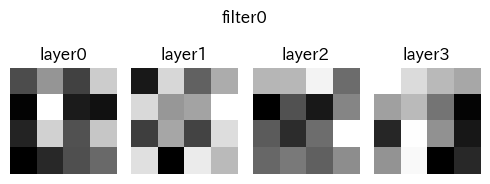

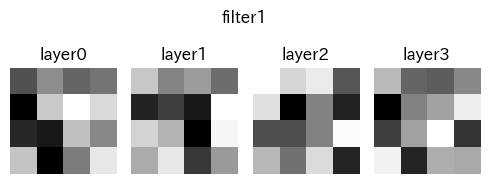

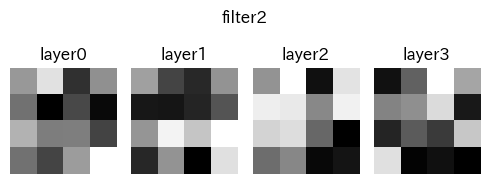

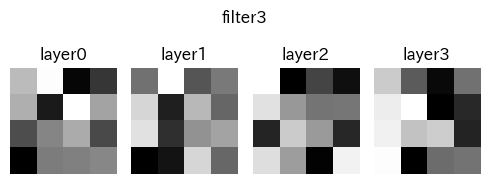

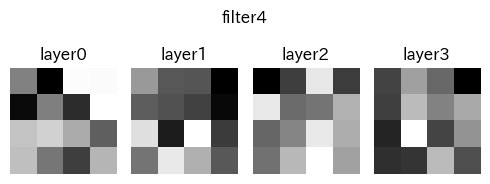

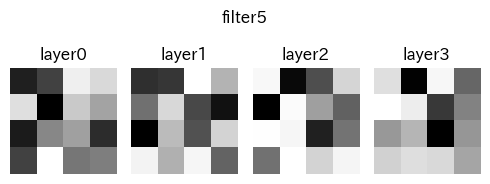

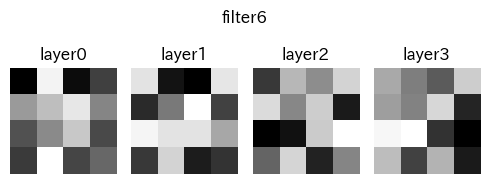

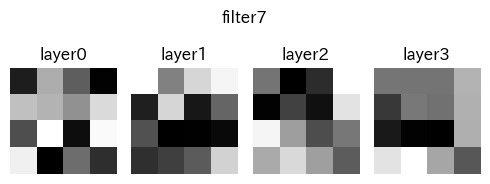

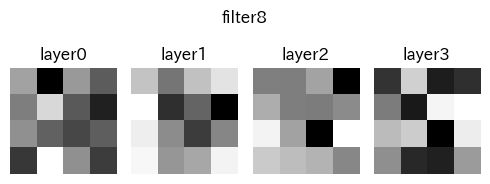

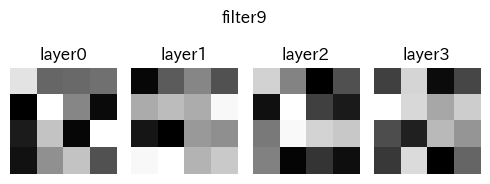

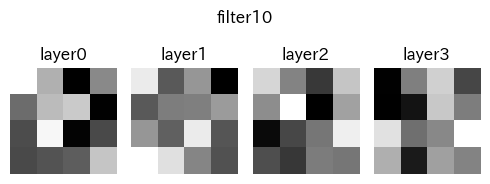

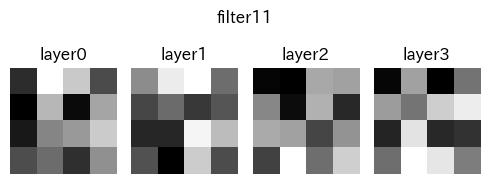

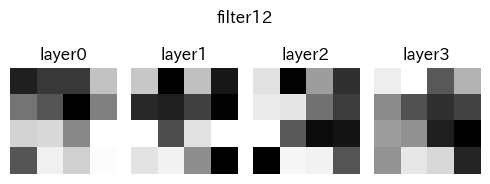

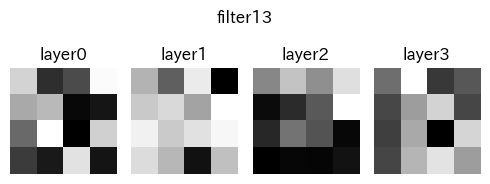

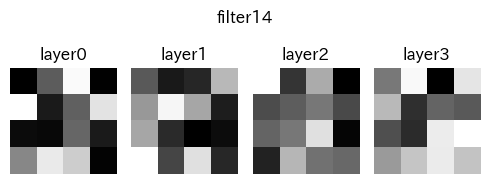

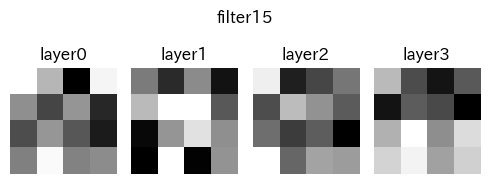

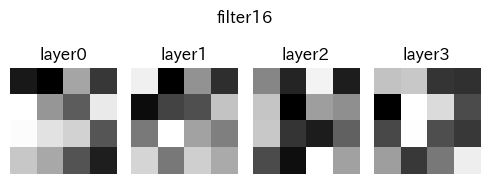

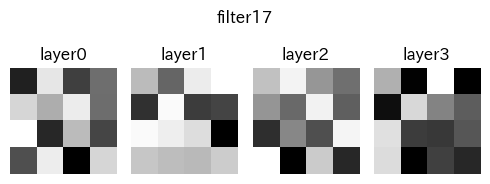

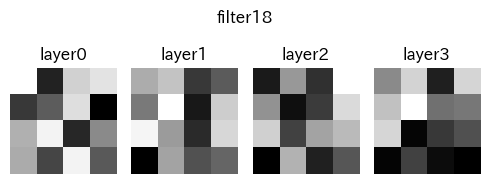

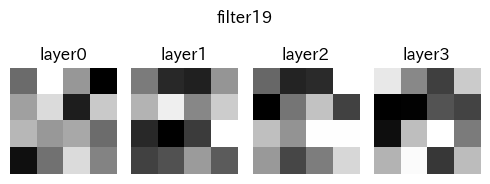

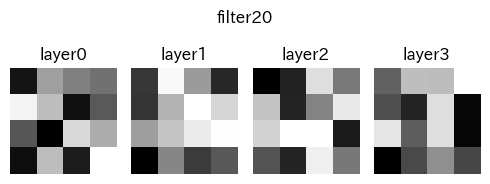

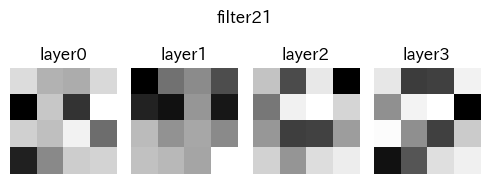

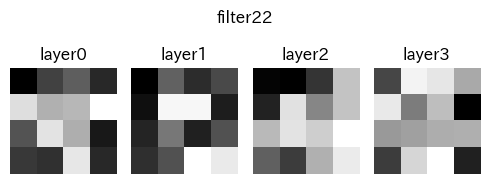

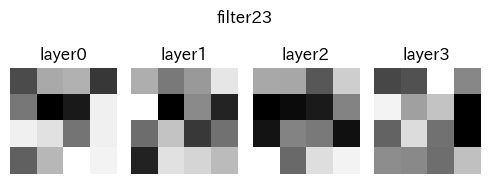

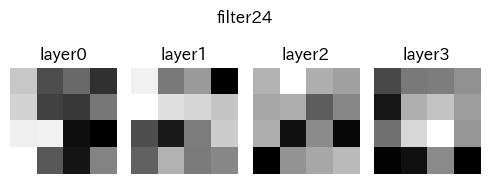

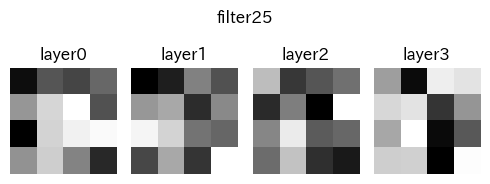

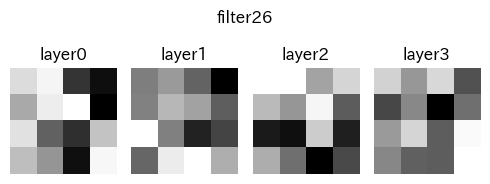

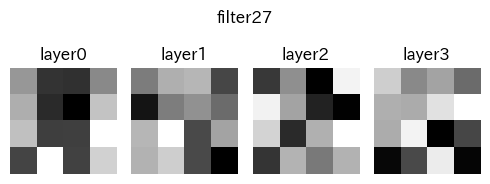

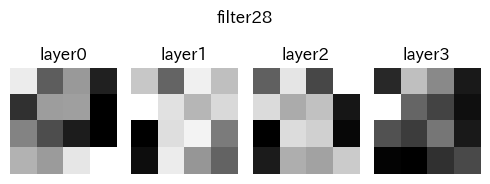

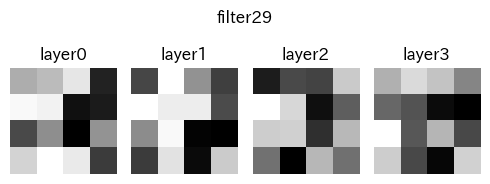

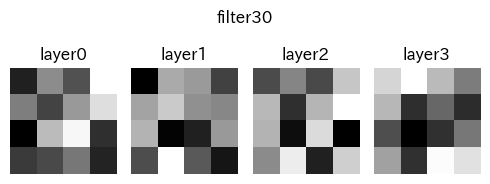

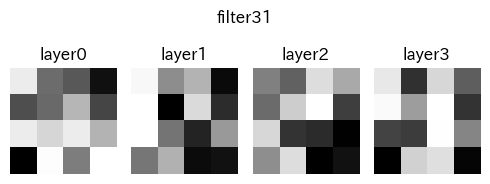

In [40]:
filters = model.state_dict()["encoder.0.weight"]

# PyTorchテンソルをNumpy配列に変換し、CPUに移動
filters = filters.detach().cpu().numpy()

print(f"フィルターの形状: {filters.shape}")
# -> (出力チャンネル数, 入力チャンネル数, 高さ, 幅)
# -> (8, 1, 3, 3)

# --- 3. フィルターを可視化 ---
num_filters = filters.shape[0]
for i in range(num_filters):
    filter = filters[i]
    filter = filter[0]
    fig, axes = plt.subplots(1, 4, figsize=(5, 2)) # 2行4列のグリッドを作成
    fig.suptitle(f"filter{i}")
    
    for j, ax in enumerate(axes.flat):
        # i番目のフィルターを取得 (入力チャンネルが1なので squeeze() で次元を削除)
        filter_img = filter[j]
        
        # imshowでフィルターを画像として表示
        ax.imshow(filter_img, cmap='gray')
        ax.set_title(f"layer{j}")
        ax.axis('off') # 軸を非表示に
    
    plt.tight_layout()
    plt.savefig(f"filater{i}.png")
    plt.show()

In [23]:
print(filters))

32


In [24]:
filter = filters[1]

In [28]:
print(filter[0][1])

[[ 0.0553522   0.00223687  0.02162655 -0.01516009]
 [-0.07187933 -0.05027495 -0.0796767   0.09889792]
 [ 0.06421991  0.03947284 -0.09976353  0.0911587 ]
 [ 0.03310191  0.08048552 -0.05484735  0.02019389]]
